In [1]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [2]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 7 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 6
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.001
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 100
    
    num_networks      = 6
    

In [3]:
import tensorflow as tf
import numpy as np
from mat4py import loadmat
import pandas as pd
from Utilities.plotting_sine import plot_sine
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.NETW import Final
from Utilities.L2_error_computation import error_L2
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.create_data_multiply import create_new_multiply
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.optimize_step_II import optimize_step
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [4]:
class Hyperparameters_new:
    max_hidden_layers = 4 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 5
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    model_cons        = 0.00001
    batch_size        = 500
    num_epochs        = 200

In [5]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [6]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



ListWrapper([2, 6, 6, 1])
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Train on 10221 samples
Epoch 1/2000
10221/10221 [==============================] - 1s 58us/sample - loss: 0.3739 - mean_squared_error: 0.3580
Epoch 2/2000
10221/10221 [==============================] - 0s 19us/sample - loss: 0.3729 - mean_squared_error: 0.3573
Epoch 3/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3729 - mean_squ

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 64/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3573
Epoch 65/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 66/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 67/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 68/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 69/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 70/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 71/2000
10221/10221 [==============================] - 

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 132/2000
10221/10221 [==============================] - 0s 5us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 133/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 134/2000
10221/10221 [==============================] - 0s 5us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 135/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 136/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 137/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 138/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 139/2000
10221/10221 [=========================

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 199/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 200/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 201/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 202/2000
10221/10221 [==============================] - 0s 15us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 203/2000
10221/10221 [==============================] - 0s 11us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 204/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 205/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 206/2000
10221/10221 [========================

10221/10221 [==============================] - 0s 9us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 267/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 268/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 269/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 270/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 271/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3573
Epoch 272/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.35720s - loss: 0.3716 - mean_squared_error: 0.35
Epoch 273/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 274/2

10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 335/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 336/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 337/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 338/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 339/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 340/2000
10221/10221 [==============================] - 0s 22us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 341/2000
10221/10221 [==============================] - 0s 16us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 342/2000
10221/10221 [=========================

10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 402/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 403/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 404/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 405/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 406/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 407/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 408/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.35710s - loss: 0.3762 - mean_squared_error: 0.36
Epoch 409/2

Epoch 469/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 470/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 471/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 472/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 473/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 474/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 475/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 476/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 477/2000
10221/10221 [============

10221/10221 [==============================] - 0s 11us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 538/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 539/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 540/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 541/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 542/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 543/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 544/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 545/2000
10221/10221 [==========================

10221/10221 [==============================] - 0s 7us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 605/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 606/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 607/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3728 - mean_squared_error: 0.3571
Epoch 608/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 609/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 610/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 611/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 612/2000
10221/10221 [===========================

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 673/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 674/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 675/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 676/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 677/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 678/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 679/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 680/2000
10221/10221 [========================

10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 741/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 742/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 743/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 744/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 745/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 746/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 747/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 748/2000
10221/10221 [===========================

10221/10221 [==============================] - 0s 11us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 809/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 810/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 811/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 812/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 813/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 814/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 815/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 816/2000
10221/10221 [==========================

10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 876/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 877/2000
10221/10221 [==============================] - 0s 12us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 878/2000
10221/10221 [==============================] - 0s 5us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 879/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 880/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 881/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 882/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 883/2000
10221/10221 [==========================

10221/10221 [==============================] - 0s 16us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 944/2000
10221/10221 [==============================] - 0s 4us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 945/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 946/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 947/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 948/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 949/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 950/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 951/2000
10221/10221 [==========================

10221/10221 [==============================] - 0s 30us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1012/2000
10221/10221 [==============================] - 0s 13us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1013/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1014/2000
10221/10221 [==============================] - 0s 4us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1015/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1016/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1017/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1018/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1019/2000
10221/10221 [=================

10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1079/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1080/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1081/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1082/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1083/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3572
Epoch 1084/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1085/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3570
Epoch 1086/2000
10221/10221 [===================

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1146/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1147/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1148/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1149/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1150/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1151/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1152/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1153/2000
10221/10221 [==================

10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1213/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3728 - mean_squared_error: 0.3572
Epoch 1214/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1215/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1216/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1217/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1218/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1219/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1220/2000
10221/10221 [===================

10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1280/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1281/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1282/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1283/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1284/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3728 - mean_squared_error: 0.3573
Epoch 1285/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1286/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1287/2000
10221/10221 [===================

10221/10221 [==============================] - 0s 9us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1347/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1348/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1349/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1350/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1351/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1352/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1353/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1354/2000
10221/10221 [===================

10221/10221 [==============================] - 0s 9us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1414/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1415/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1416/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1417/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1418/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1419/2000
10221/10221 [==============================] - 0s 13us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1420/2000
10221/10221 [==============================] - 0s 13us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1421/2000
10221/10221 [================

10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1481/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1482/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1483/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1484/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1485/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1486/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1487/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1488/2000
10221/10221 [===================

10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1548/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1549/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1550/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1551/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1552/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1553/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1554/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1555/2000
10221/10221 [===================

10221/10221 [==============================] - 0s 11us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1615/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1616/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1617/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1618/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1619/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1620/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1621/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3727 - mean_squared_error: 0.3571
Epoch 1622/2000
10221/10221 [==================

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1682/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1683/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1684/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1685/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1686/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1687/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1688/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1689/2000
10221/10221 [==================

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1749/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1750/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1751/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1752/2000
10221/10221 [==============================] - 0s 9us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1753/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1754/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1755/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1756/2000
10221/10221 [==================

10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1816/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1817/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1818/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1819/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3725 - mean_squared_error: 0.3571
Epoch 1820/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1821/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1822/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1823/2000
10221/10221 [===================

10221/10221 [==============================] - 0s 8us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1883/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1884/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1885/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3725 - mean_squared_error: 0.3569
Epoch 1886/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1887/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1888/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1889/2000
10221/10221 [==============================] - 0s 6us/sample - loss: 0.3726 - mean_squared_error: 0.3571
Epoch 1890/2000
10221/10221 [================

10221/10221 [==============================] - 0s 10us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1950/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3726 - mean_squared_error: 0.3570
Epoch 1951/2000
10221/10221 [==============================] - 0s 10us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1952/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1953/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3569
Epoch 1954/2000
10221/10221 [==============================] - 0s 7us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1955/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1956/2000
10221/10221 [==============================] - 0s 8us/sample - loss: 0.3725 - mean_squared_error: 0.3570
Epoch 1957/2000
10221/10221 [=================

<Figure size 432x288 with 0 Axes>

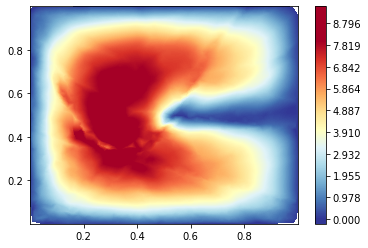

In [10]:
if __name__ == "__main__":     

    trainable=2
    gauss_solution=np.loadtxt("gauss_solution.data")
    gauss_solution = tf.cast(gauss_solution,tf.float32)
    

    
    gauss_points_new = loadmat('gauss_points_new.mat')
    gauss_points_new=np.array(list(gauss_points_new.values()))[-1]
    gauss_points_new = tf.cast(gauss_points_new,tf.float32)
    

    
    gauss_weights_new = loadmat('gauss_weights_new.mat')
    gauss_weights_new=np.array(list(gauss_weights_new.values()))[-1].squeeze(-1)

    
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    solution = loadmat('Solution.mat')
    solution=np.array(list( solution.values()))[-1]
    solution=tf.cast( solution,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    
    data_train_length=len(data_train)

    


    
    #for i in range(1,hyperp.num_networks):
    for i in range(10,11):
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
        if i>1:
            trainable=2

    
            
        if trainable==2:
        
        
        
            #=== GPU Settings ===#
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
            os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
            if run_options.use_L1 == 0:
                kernel_regularizer = None
                bias_regularizer = None  
            else:
                kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
                bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            
            
            multiply=0
        
            if multiply==0:

                data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i,Coordinates,solution)
        
            if multiply==1:

                data_train,new_label,labels_train=create_new_multiply(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
     
        #=== Construct Validation Set and Batches ===# 
            data_and_labels_train, data_and_labels_val, data_and_labels_test,\
            num_data_train, num_data_val, num_data_test,\
            num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
            = form_train_val_test_batches(data_train, labels_train, \
                                      data_test, labels_test, \
                                      hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if i==1 and trainable==2:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
            NN._set_inputs( data_train)

    #=== Training ===#
    #                                 Training                                    #
###############################################################################
        if trainable>2:
            del NN
            NN = Final(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer,trainable)   
            #NN._set_inputs(data_train)
            NN.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable-1))
            #NN=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(1)+str(trainable-1))
        


        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,trainable)   
        
        if i>1:


            optimize_step(data_train,new_label,data_test, labels_test,i,label_dimensions,hyperp,hyperp_new,run_options,data_input_shape,data_loss_regression,error_L2,gauss_points_new,gauss_solution,gauss_weights_new,data_train_length,Stiffness,hyperp_new.model_cons)
        #NN.save("WEIGHTS"+'/'+"model"+str(1)+str(trainable))
        #if not os.path.exists("WEIGHTS"):
            #os.makedirs("WEIGHTS")
        #NN.save_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable))
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i,trainable+1)
            
        #if i>1:
            #plot_fig(hyperp_new, run_options, file_paths,i,3)
        
        
        plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,i,data_train, labels_train,labels_test)
        
   
        
        
        
        
        
        
        
        

In [32]:
    trainable=2
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 

<tf.Tensor: id=1123, shape=(), dtype=float32, numpy=2.0>

<tf.Tensor: id=1119, shape=(5000,), dtype=float32, numpy=
array([ 1.0323483 , -0.12156244,  1.0937504 , ...,  0.7032321 ,
        1.3476135 ,  5.3076773 ], dtype=float32)>

In [13]:
ll=tf.reshape(labels_train,(len(labels_train),1))
tf.reduce_mean(tf.square(Network(data_train)-ll))

<tf.Tensor: id=170707, shape=(), dtype=float32, numpy=1.611958>

In [15]:
np.mean(Network(data_train))

3.398217

In [41]:
labels_train

<tf.Tensor: id=10706, shape=(7140,), dtype=float32, numpy=
array([2.7816584, 7.2161684, 6.0261307, ..., 5.7437162, 9.157393 ,
       3.8458078], dtype=float32)>

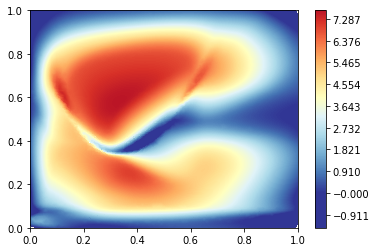

In [39]:
    import matplotlib.pyplot as plt
    y_pred_test_add=Network(data_test)
    x = data_test[:,0]
    y = data_test[:,1]
        
    fig, ax = plt.subplots()
    clevels = np.linspace(np.amin(y_pred_test_add), np.amax(y_pred_test_add), 10000)
    #v = np.linspace(0, 8, 10, endpoint=True)
    im = ax.tricontourf(x, y, y_pred_test_add[:,0], clevels, cmap='RdYlBu_r',vmax=8, vmin=0.)
    
    plt.colorbar(im)
    plt.show()

In [12]:
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))

In [8]:
    solution = loadmat('Solution.mat')
    solution=np.array(list( solution.values()))[-1]
    solution=tf.cast( solution,tf.float32)


In [9]:
len(solution)

3721

ListWrapper([2, 6, 6, 1])


<Figure size 432x288 with 0 Axes>

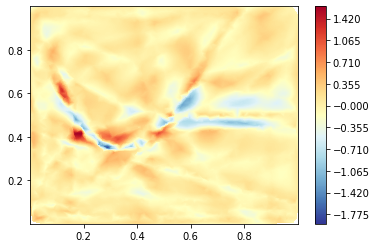

In [8]:
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    
plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,10,data_train, labels_train,labels_test)
        

In [20]:
solution

<tf.Tensor: id=31, shape=(3721,), dtype=float32, numpy=
array([ 0.0000000e+00,  7.7037198e-33,  1.2089007e-01, ...,
       -2.5353599e-16,  6.7107641e-18,  3.3553821e-18], dtype=float32)>

In [21]:
new_train=tf.concat((data_train,Coordinates), axis=0)
new_label=tf.concat((labels_train,solution), axis=0)

In [22]:
new_label

<tf.Tensor: id=35, shape=(10861,), dtype=float32, numpy=
array([ 2.7816584e+00,  7.2161684e+00,  6.0261307e+00, ...,
       -2.5353599e-16,  6.7107641e-18,  3.3553821e-18], dtype=float32)>

In [7]:
    trainable=2
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 

ListWrapper([2, 6, 6, 1])


<Figure size 432x288 with 0 Axes>

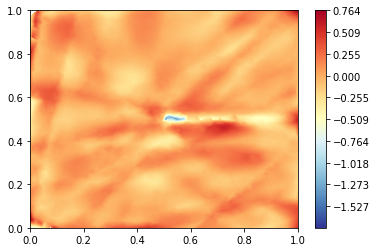

In [8]:
plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,17,data_train, labels_train,labels_test)
        

In [11]:
x_train=data_train
y_train=new_label


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Dense(5, activation='linear', input_shape=(2,)))
model.add(layers.Dense(5, activation='elu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
model.fit(x_train,y_train,batch_size=100,epochs=300,verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
Train on 10248 samples
Epoch 1/300
10248/10248 [==============================] - 1s 53us/sample - loss: 0.1922 - mean_squared_error: 0.1922
Epoch 2/300
10248/10248 [==============================] - 0s 14us/sample - loss: 0.1718 - mean_squared_error: 0.1718
Epoch 3/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1719 - mean_squared_error: 0.1719
Epoch 4/30

10248/10248 [==============================] - 0s 12us/sample - loss: 0.1362 - mean_squared_error: 0.1362
Epoch 132/300
10248/10248 [==============================] - 0s 12us/sample - loss: 0.1348 - mean_squared_error: 0.1348
Epoch 133/300
10248/10248 [==============================] - 0s 12us/sample - loss: 0.1348 - mean_squared_error: 0.1348
Epoch 134/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1356 - mean_squared_error: 0.1356
Epoch 135/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1353 - mean_squared_error: 0.1353
Epoch 136/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1349 - mean_squared_error: 0.1349
Epoch 137/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1366 - mean_squared_error: 0.1366
Epoch 138/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1352 - mean_squared_error: 0.1352
Epoch 139/300
10248/10248 [===========================

Epoch 267/300
10248/10248 [==============================] - 0s 12us/sample - loss: 0.1355 - mean_squared_error: 0.1355
Epoch 268/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1362 - mean_squared_error: 0.1362
Epoch 269/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1350 - mean_squared_error: 0.1350
Epoch 270/300
10248/10248 [==============================] - 0s 12us/sample - loss: 0.1351 - mean_squared_error: 0.1351
Epoch 271/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1352 - mean_squared_error: 0.1352
Epoch 272/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1352 - mean_squared_error: 0.1352
Epoch 273/300
10248/10248 [==============================] - 0s 13us/sample - loss: 0.1347 - mean_squared_error: 0.1347
Epoch 274/300
10248/10248 [==============================] - 0s 12us/sample - loss: 0.1346 - mean_squared_error: 0.1346
Epoch 275/300
10248/10248 [=============

KeyboardInterrupt: 

In [13]:
            Network=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(2-1))
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(2-1)+'.h5')
            y_pred,r=Network(data_train)

ValueError: too many values to unpack (expected 2)

In [11]:
plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,1,data_train, labels_train)
        
   

NameError: name 'hyperp_new' is not defined

5965

In [14]:
hidden_layers_list[0]=1

SyntaxError: can't assign to operator (<ipython-input-30-baf321f0c7a6>, line 1)

In [25]:
"WEIGHTS"+'/'+"model_weights"+str(i_val)
hidden_layers_list.insert(0, NoDependency(1))        


In [29]:
hidden_layers_list[0]

TypeError: 'NoDependency' object does not support indexing

In [11]:
hidden_layers_list

[1]

In [12]:
len(hidden_layers_list)

1

In [9]:
            Network=Final_Network( hyperp,run_options, data_input_shape, label_dimensions) 
        
            Network.load_weights("WEIGHTS"+'/'+"model_weights"+str(2-1)).expect_partial()
    
            y_pred=Network(data_train)


ListWrapper([2, 6, 6, 1])


In [11]:
new_label=tf.reshape(new_label,(len(y_pred),1))

In [38]:
y_pred

<tf.Tensor: id=1459128, shape=(354, 1), dtype=float32, numpy=
array([[33.76945  ],
       [26.26653  ],
       [27.390202 ],
       [16.94542  ],
       [17.081976 ],
       [32.343895 ],
       [27.67299  ],
       [24.495663 ],
       [22.398619 ],
       [26.520485 ],
       [35.224224 ],
       [-2.244073 ],
       [ 6.259705 ],
       [38.08592  ],
       [17.74724  ],
       [32.85308  ],
       [24.74735  ],
       [ 8.830112 ],
       [31.070496 ],
       [24.71079  ],
       [30.053083 ],
       [30.796227 ],
       [35.541714 ],
       [32.961033 ],
       [21.649975 ],
       [28.837845 ],
       [21.118425 ],
       [22.64952  ],
       [29.759092 ],
       [26.474918 ],
       [34.143085 ],
       [27.279566 ],
       [22.111225 ],
       [32.622135 ],
       [32.75378  ],
       [21.810385 ],
       [30.475466 ],
       [25.062466 ],
       [31.382488 ],
       [20.840607 ],
       [ 6.8198676],
       [26.091671 ],
       [13.0004635],
       [ 9.380229 ],
       [ 4.024

In [37]:
new_label

<tf.Tensor: id=1459150, shape=(354, 1), dtype=float32, numpy=
array([[35.2],
       [25. ],
       [36.2],
       [16.1],
       [10.9],
       [36.4],
       [25. ],
       [20.1],
       [16.8],
       [23.7],
       [42.3],
       [17.9],
       [12.7],
       [50. ],
       [18.4],
       [33.4],
       [22.9],
       [14.6],
       [29.9],
       [22.6],
       [22.5],
       [29. ],
       [50. ],
       [37.9],
       [21.4],
       [29.4],
       [20.3],
       [23. ],
       [30.1],
       [21.7],
       [36.5],
       [25. ],
       [24.5],
       [37.3],
       [33.8],
       [24.7],
       [32.7],
       [23.1],
       [25.1],
       [21.7],
       [13.4],
       [24.8],
       [12.7],
       [11.8],
       [ 8.3],
       [20.2],
       [41.3],
       [23.2],
       [23.1],
       [24.3],
       [19.3],
       [10.8],
       [18.6],
       [29. ],
       [23.9],
       [19.5],
       [13.1],
       [31.7],
       [21. ],
       [18.2],
       [21. ],
       [21.2],
       [

In [12]:
np.multiply(new_label,y_pred)

array([[1188.6847  ],
       [ 656.6632  ],
       [ 991.5253  ],
       [ 272.82126 ],
       [ 186.19353 ],
       [1177.3179  ],
       [ 691.82477 ],
       [ 492.36282 ],
       [ 376.29678 ],
       [ 628.5355  ],
       [1489.9846  ],
       [ -40.168903],
       [  79.49825 ],
       [1904.2959  ],
       [ 326.54922 ],
       [1097.293   ],
       [ 566.7143  ],
       [ 128.91965 ],
       [ 929.0078  ],
       [ 558.46387 ],
       [ 676.1944  ],
       [ 893.0906  ],
       [1777.0857  ],
       [1249.2231  ],
       [ 463.30945 ],
       [ 847.83264 ],
       [ 428.704   ],
       [ 520.93896 ],
       [ 895.7487  ],
       [ 574.50574 ],
       [1246.2227  ],
       [ 681.98914 ],
       [ 541.72504 ],
       [1216.8057  ],
       [1107.0778  ],
       [ 538.7165  ],
       [ 996.5477  ],
       [ 578.943   ],
       [ 787.70044 ],
       [ 452.24118 ],
       [  91.38622 ],
       [ 647.0734  ],
       [ 165.10588 ],
       [ 110.68671 ],
       [  33.401306],
       [ 4

In [15]:
ff=data_and_labels_train_new.shuffle(num_data_train,seed=random_seed)
            
data_and_labels_train_new_new = ff.batch(batch_size)
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train_new_new.enumerate():
    labels

In [19]:
x_train_new = batch_data_train[batch_labels_train == 1]


In [21]:
batch_pred_train,val=NN(x_train_new)
dimension=np.shape(val)
        

length=len(x_train_new)

In [26]:
new_one=val[1:length]

In [29]:
sum_val = 0.1*length*dimension[1]*tf.math.reduce_mean(tf.keras.losses.mean_squared_error(new_one, val[0:length-1]))

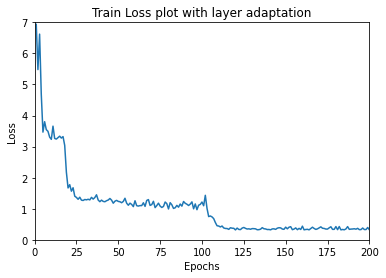

In [21]:
    import matplotlib.pyplot as plt
    storage_loss_array=[]
    storage_accuracy_array=[]
    max_hidden_layers=7
    no_epoch=hyperp.num_epochs
    
    for i in range(2,max_hidden_layers):
    
        trainable_hidden_layer_index=i
    
    
        name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


        df_metrics =pd.read_csv(name)

        array_metrics = df_metrics.to_numpy()

        storage_loss_array=np.concatenate((storage_loss_array, array_metrics[:,0]), axis=0)
 
        storage_accuracy_array=np.concatenate((storage_accuracy_array, array_metrics[:,1]), axis=0)
    
    if not os.path.exists("plots"):
        os.makedirs("plots")
#=== Plot and Save Losses===#
    fig_loss = plt.figure()
    x_axis = np.linspace(1, len(storage_loss_array), len(storage_accuracy_array), endpoint = True)
    plt.plot(x_axis, storage_accuracy_array)
    plt.title('Train Loss plot with layer adaptation' )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0,7)
    plt.xlim(0,200)
    fig_loss.savefig("plots"+'/'+"loss"+str(1)+'.png')


In [20]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,new_label)).shuffle(num_data_train, seed=random_seed)

array([[0.35918419, 0.28422403, 0.10307025, ..., 0.        , 0.        ,
        0.62466817],
       [0.32605052, 0.24233485, 0.08812176, ..., 0.88121761, 0.        ,
        0.        ],
       [0.29166546, 0.22884521, 0.07628174, ..., 0.44871611, 0.        ,
        0.        ],
       ...,
       [0.2655331 , 0.20324756, 0.0721201 , ..., 0.        , 0.65563727,
        0.        ],
       [0.28990458, 0.23060589, 0.07906488, ..., 0.43924934, 0.        ,
        0.        ],
       [0.34885539, 0.26677175, 0.09850034, ..., 0.        , 0.        ,
        0.82083619]])

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets
kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
(data_train, labels_train), (data_test, labels_test) = datasets.cifar10.load_data()
#(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
#data_train = tf.reshape(data_train, (len(data_train), 28*28))
#data_test = tf.reshape(data_test, (len(data_test), 28*28))
data_train = tf.reshape(data_train, (len(data_train), 32*32*3))
data_test = tf.reshape(data_test, (len(data_test), 32*32*3))
    
label_dimensions = 10
data_input_shape = data_train.shape[1:]

In [28]:
labels_train=np.squeeze(labels_train,axis=1)

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [8]:
Network=Final_Network(hyperp, run_options, data_input_shape, label_dimensions,
                      kernel_regularizer, bias_regularizer) 

ListWrapper([28, 10, 10, 10])


In [9]:
Network.load_weights("WEIGHTS"+'/'+"model_weights1")

In [10]:
num_data_train = len(data_train)
data_and_labels_train_new = data_and_labels_train_full.take(num_data_train)

NameError: name 'data_and_labels_train_full' is not defined

In [9]:
ff=data_and_labels_train_new.shuffle(num_data_train,seed=random_seed)
batch_size=100           
data_and_labels_train_new_new = ff.batch(batch_size)

NameError: name 'random_seed' is not defined

In [8]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train_new_new.enumerate():
    labels

NameError: name 'data_and_labels_train_new_new' is not defined

In [35]:
x_train_new = batch_data_train[batch_labels_train == 0]

<tf.Tensor: id=257704, shape=(8, 10), dtype=float64, numpy=
array([[0.3567994 , 0.28774145, 0.08440416, 0.38365526, 0.16113521,
        0.08670609, 0.11548023, 0.        , 0.        , 0.76731053],
       [0.29701502, 0.23368094, 0.08080556, 0.70191636, 0.31645203,
        0.14042695, 0.21751982, 0.        , 0.        , 0.43678679],
       [0.34182954, 0.26751877, 0.09809022, 0.5739764 , 0.29605411,
        0.11295237, 0.13673182, 0.        , 0.        , 0.59448617],
       [0.31044639, 0.24704538, 0.08744969, 0.70003475, 0.3086974 ,
        0.14035676, 0.1967618 , 0.        , 0.        , 0.43724845],
       [0.28379031, 0.22466732, 0.07883064, 0.72031496, 0.3622268 ,
        0.14426007, 0.1911643 , 0.        , 0.        , 0.39415319],
       [0.33470906, 0.26276223, 0.10322803, 0.57526161, 0.20989698,
        0.12418644, 0.16266233, 0.        , 0.        , 0.62562438],
       [0.3415542 , 0.25898065, 0.11260029, 0.43501245, 0.12648766,
        0.09383357, 0.16139374, 0.        , 0.    

In [10]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_test = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(batch_size)
num_batches_test = len(list(data_and_labels_test))

#=== Partitioning Out Validation Set and Constructing Batches ===#
current_num_data_train = num_data_train
num_data_train = int(0.8 * num_data_train)
num_data_val = current_num_data_train - num_data_train
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [23]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

In [24]:
labels=tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [25]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,labels)).shuffle(num_data_train, seed=random_seed)

In [26]:
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [32]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train.enumerate():
    batch=batch_num
    batch_data_train = batch_data_train
    batch_labels_train=batch_labels_train
    lab=labels

In [36]:
lab


<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [20]:
y_true = tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [21]:
y_true

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [37]:
np.mean(tf.keras.losses.mean_squared_error(new_one, val[0:dimension[0]-1]))

1.9269863

array([4, 6, 6, ..., 7, 2, 5])

In [19]:

x_train_new = batch_data_train[batch_labels_train == 1]
batch_pred_train,val=NN(x_train_new)



In [16]:
y_true = tf.one_hot(tf.cast(y_true,tf.int64), label_dimensions, dtype=tf.float32)

In [45]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.6097095>

In [48]:
np.linalg.norm(val[0]-val[1])

2.567157